In [1]:
%matplotlib inline
import random

from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4
import parcels
from datetime import timedelta, datetime
import numpy as np

import matplotlib.pyplot as plt

import netCDF4

In [125]:
a = netCDF4.Dataset('../data/world_oscar_vel_5d2018.nc')
a

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    year: 2018
    description: Sea Surface Velocity
    version: 2006.0
    source: Gary Lagerloef, ESR (lager@esr.org) Fabrice Bonjean (bonjean@esr.org) and Kathleen Dohan (kdohan@esr.org)
    contact: Kathleen Dohan (kdohan@esr.org) or John T. Gunn (gunn@esr.org)
    company: Earth & Space Research, Seattle, WA
    reference1: Bonjean F. and G.S.E. Lagerloef, 2002 ,"Diagnostic model and analysis of the surface currents in the tropical Pacific ocean", J. Phys. Oceanogr., 32, 2,938-2,954
    date: 08-Mar-2019
    note: Longitude extends from 20.5 E to 419.5 E to avoid a break in major ocean basins. Data repeats in overlap region.
    dimensions(sizes): latitude(140), longitude(360), time(72), depth(1)
    variables(dimensions): float32 latitude(latitude), float32 longitude(longitude), int32 time(time), int32 date(time), float32 depth(depth), int32 mask(latitude,longitude), float32 u(time,d

In [132]:
# a.variables['u'][:,:,a.variables['latitude'][:]==10.5,a.variables['longitude'][:]==9.5]

In [133]:
# a.variables['longitude'][:]

In [55]:
filenames = {
    'U': "../data/world_oscar_vel_5d2018.nc",
    'V': "../data/world_oscar_vel_5d2018.nc"
}

variables = {
    'U': 'u',
    'V': 'v'
}

dimensions = {
    'lat': 'latitude',
    'lon': 'longitude',
    'time': 'time'
}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

In [6]:
def generate_points(lon, lat, start_time, spread=0.1, N=10):
    lons, lats, times = [], [], []
    
    curr_time = start_time #+ timedelta(hours=random.randint(0, 5))
    for _ in range(N):
        lons.append(random.gauss(lon, spread))
        lats.append(random.gauss(lat, spread))
        times.append(curr_time)
        
#         curr_time += timedelta(minutes=random.randint(0, 60))
    
    return lons, lats, times

coords = {
#     'St Tropez': [43, 6.641068],
    'Barcelona': [41, 2.195182],
#     'Napoli': [40.7, 13.5],
#     'Beirut': [33.917980, 35],
    'Tripoli': [33.5, 13.161539],
    'Sicilia': [36.8, 14.3],
    'Athens': [36.895174, 21.499637]
    
}
coords_scs = {
    'Manila': [14.311412, 120.424967],
    'Honk Kong': [22.200365, 114.355471],
    'Singapore': [1.347300, 104.545996]
}

init_lons, init_lats, init_times = [], [], []

start_time = datetime(2018, 1, 1)
for location, local_coords in coords.items():
    lons, lats, times = generate_points(lat=local_coords[0], lon=local_coords[1], start_time=start_time)
    
    init_lons.extend(lons)
    init_lats.extend(lats)
    init_times.extend(times)

pset = ParticleSet.from_list(
    fieldset=fieldset,
    pclass=JITParticle,
    lon=init_lons,
    lat=init_lats,
    time=init_times,
    repeatdt=5000000
)

NameError: name 'fieldset' is not defined

In [5]:
domain_scs = {'N': 25, 'S': 0, 'E': 125, 'W': 100}
europe = {'N': 47, 'S': 30, 'E':30, 'W':-5}
pset.show(domain=europe)

NameError: name 'pset' is not defined

/home/ubuntu/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/ubuntu/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


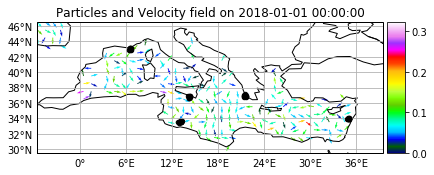

In [95]:
pset.show(domain=europe, field='vector')

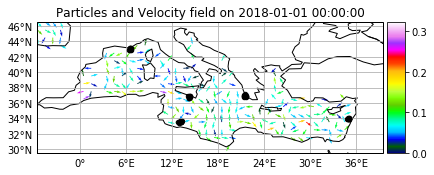

In [96]:
pset.show(domain=europe, field='vector')

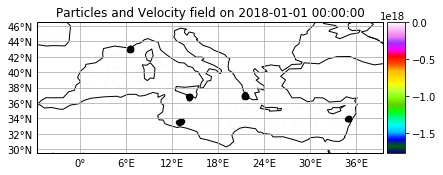

In [97]:
pset.show(domain=europe, field='vector')

In [113]:
print(pset[0])
pset.execute(AdvectionRK4, runtime=timedelta(days=120), dt=timedelta(hours=5))
print(pset[0])

P[8050](lon=9.099672, lat=44.387604, depth=0.000000, time=31622400.000000)
P[8050](lon=8.951372, lat=44.469612, depth=0.000000, time=41990400.000000)


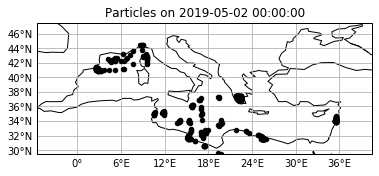

In [114]:
pset.show(domain=europe)

In [2]:
# Functions to generate trajectories

coords = {
    'Barcelona': [41, 2.195182],
    'Tripoli': [33.5, 13.161539],
    'Sicilia': [36.8, 14.3],
    'Athens': [36.895174, 21.499637]
}

europe = {'N': 47, 'S': 30, 'E':30, 'W':-5}


class Simulator:
    def __init__(self, fname="../data/sv04-med-ingv-cur-an-fc-d_1552135429007.nc", coords_dict=coords, spread=0.05, N=10,
                repeat_release=None):
        # Generate the fieldset
        self.filenames = {'U': fname, 'V': fname}
        self.variables = {'U': 'uo','V': 'vo'}
        self.dimensions = {
            'lat': 'lat',
            'lon': 'lon'
        }
        
        # Save init parameters
        self.spread = spread
        self.N = N
        self.repeat_release = repeat_release # Should be interval in seconds
        
        # Load fieldset
        self.fieldset = FieldSet.from_netcdf(self.filenames, self.variables, self.dimensions, allow_time_extrapolation=True)
        self.coords_dict = coords_dict
        self._init_particle_set()
        
    def _generate_points(self, lon, lat, start_time):
        lons, lats, times = [], [], []

        curr_time = start_time #+ timedelta(hours=random.randint(0, 5))
        for _ in range(self.N):
            lons.append(random.gauss(lon, self.spread))
            lats.append(random.gauss(lat, self.spread))
            times.append(curr_time)

#             curr_time += timedelta(minutes=random.randint(0, 60))

        return lons, lats, times
    
    def _get_coordinates(self, pset):
        coords = dict()
        for p in pset:
            coords[p.id]=self._transform_longlat(p.lon, p.lat)
        return coords
    
    def _transform_longlat(self, lon, lat):
        factor = 100
        return [round(factor*lon)-factor*europe['W'], round(factor*lat)-factor*europe['S']]
    
    def _init_particle_set(self):
        init_lons, init_lats, init_times = [], [], []

        start_time = datetime(2018, 1, 1)
        for location, local_coords in self.coords_dict.items():
            lons, lats, times = self._generate_points(lat=local_coords[0], 
                                                      lon=local_coords[1], 
                                                      start_time=start_time)

            init_lons.extend(lons)
            init_lats.extend(lats)
            init_times.extend(times)

        self.pset = ParticleSet.from_list(
            fieldset=self.fieldset,
            pclass=JITParticle,
            lon=init_lons,
            lat=init_lats,
#             time=init_times,
            repeatdt=self.repeat_release
        )
        
    def run_simulation(self, runtime=360):
        self.pset_coordinates = []
        timestep=1
        for i in range(int(runtime/timestep)):
            if i%50 == 0:
                print(f'{int((i+1)*timestep)} days simulated')
                self.pset.show()
            self.pset.execute(AdvectionRK4, runtime=timedelta(days=timestep), dt=timedelta(hours=1))
            self.pset_coordinates.append(self._get_coordinates(self.pset))
        
        return self.pset_coordinates
        

In [3]:
# Generate new plastics 
seed = 2
parcels.rng.seed(seed)
np.random.seed(seed)
sim = Simulator(repeat_release=2.5e6, N=100, spread=0.2)

INFO: Compiled random ==> /tmp/parcels-1000/parcels_random_028eebfa-2128-4b39-81e4-17b0512a88a8.so


1 days simulated


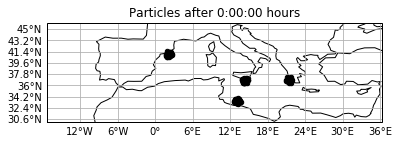

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/dfd37d8277e0b9c9a36d0aa46c0bcd26.so


51 days simulated


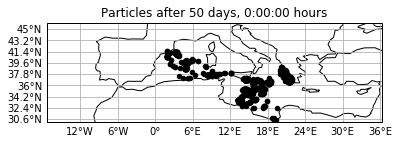

101 days simulated


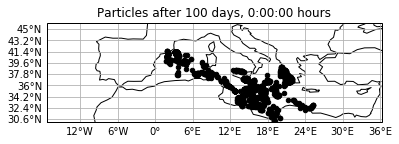

151 days simulated


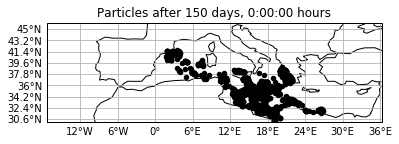

201 days simulated


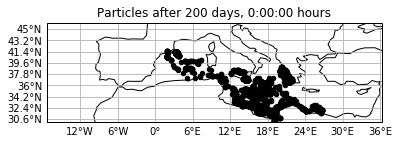

251 days simulated


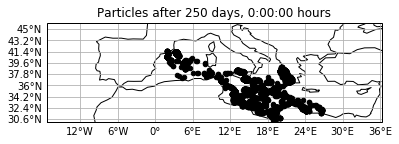

301 days simulated


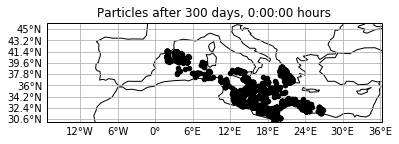

351 days simulated


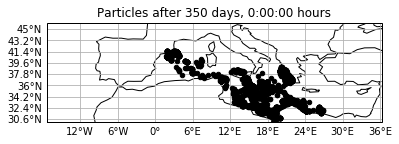

In [4]:
res_dict = sim.run_simulation()

In [7]:
import pickle

pickle.dump(res_dict,  open(f'../output/coord_dict_large_s{seed}.p', 'wb'))

In [7]:
len(sim.pset)

5200